In [1]:
'''
Visualize the data generated from src/cut_and_project/three_dim_commuting.py
'''
import os
import numpy as np
import matplotlib.pyplot as plt
from aperiodic_codes import cut_and_project
data_folder = '../data/apc/6d_to_3d/'
n = 3

%matplotlib widget

In [2]:
# check commutation in 5D
#hx = np.load(os.path.join(data_folder, f'hx_n={n}.npy'))
#hz = np.load(os.path.join(data_folder, f'hz_n={n}.npy'))
#assert hx.shape[1] == hz.shape[1]
#assert np.sum(hx @ hz.T % 2) < 1e-5
# assert np.allclose(hx @ hz.T % 2, np.zeros_like(hx @ hz.T))
# assert np.allclose(hz @ hx.T % 2, np.zeros_like(hz @ hx.T))

# for i in range(hx.shape[0]):
#     assert np.sum(hx[i]) == 5, f"{np.sum(hx[i])}"

# for i in range(hz.shape[0]):
#     assert np.sum(hz[i]) == 5, f"{np.sum(hz[i])}"

Number of points: 1980


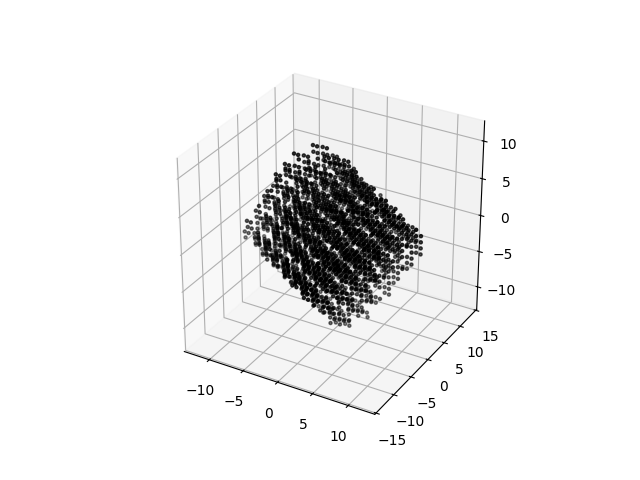

In [3]:
# visualize points in 3D
pid = 468936;
data = np.load(os.path.join(data_folder, f'{pid}.npz'))
proj_pts = data['proj_pts'];
n_points = proj_pts.shape[0];
print(f'Number of points: {n_points}');

cut_bulk = data['cut_bulk'];

fig = plt.figure();
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1,1,1])
ax.scatter(proj_pts[:,0], proj_pts[:,1], proj_pts[:,2],color='k',s=5);
plt.show();

In [4]:
# check anti-commutation between X and Z checks
new_hx_cc = data['hx_cc'];
new_hx_vv = data['hx_vv'];
new_hz_cc = data['hz_cc'];
new_hz_vv = data['hz_vv'];

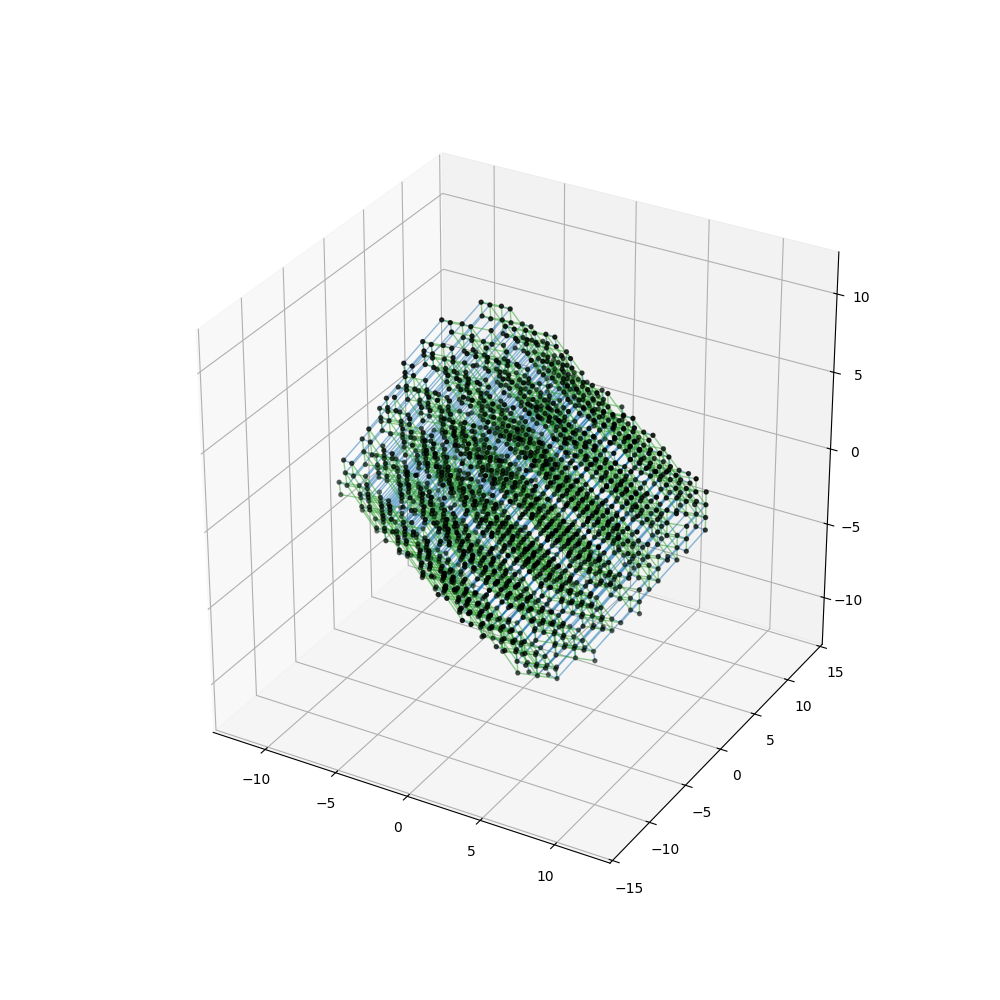

In [5]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1,1,1])
for i in range(new_hx_cc.shape[0]):
    for j in range(new_hx_cc.shape[1]):
        if new_hx_cc[i,j] != 0:
            ax.plot([proj_pts[i,0],proj_pts[j,0]],[proj_pts[i,1],proj_pts[j,1]],zs=[proj_pts[i,2],proj_pts[j,2]],color='C0',lw=1,alpha=0.5);
for i in range(new_hz_cc.shape[0]):
    for j in range(new_hz_cc.shape[1]):
        if new_hz_cc[i,j] != 0:
            ax.plot([proj_pts[i,0],proj_pts[j,0]],[proj_pts[i,1],proj_pts[j,1]],zs=[proj_pts[i,2],proj_pts[j,2]],color='C2',lw=1,alpha=0.5);
ax.scatter(proj_pts[:,0], proj_pts[:,1],proj_pts[:,2],color='k',s=8);

#lmask = [2,197%proj_pts.shape[1]];
#ax.scatter(proj_pts[0,lmask],proj_pts[1,lmask],color='r',marker='*',s=100);
plt.show()

In [6]:
new_hx = np.hstack([new_hx_cc, new_hx_vv])
new_hz = np.hstack([new_hz_cc, new_hz_vv])
# anti_comm_mat_x = (new_hx @ new_hz.T) % 2
anti_comm_mat_x = (new_hx @ new_hz.T)[np.ix_(cut_bulk,cut_bulk)] % 2

In [7]:
np.sum(anti_comm_mat_x)

218

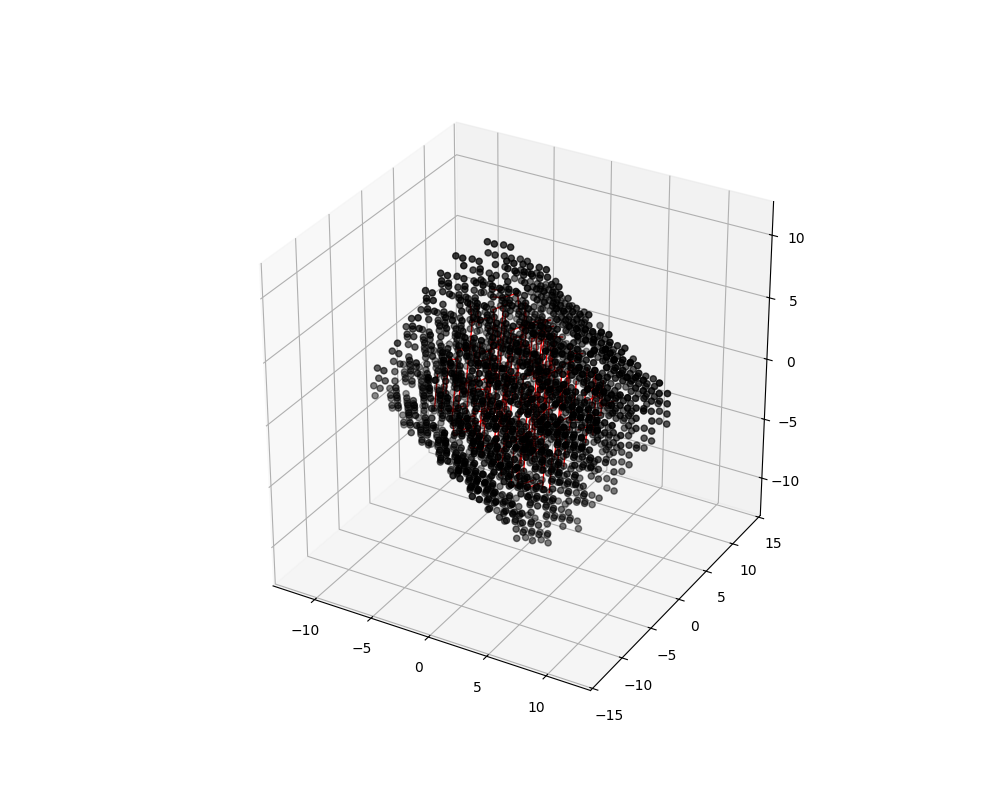

In [8]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1,1,1])
for i in range(anti_comm_mat_x.shape[0]):
    for j in range(anti_comm_mat_x.shape[1]):
        if anti_comm_mat_x[i,j] != 0:
            if i == j:
                i_proj = cut_bulk[i]
                ax.scatter([proj_pts[i_proj,0]],[proj_pts[i_proj,1]],[proj_pts[i_proj,2]],color='r',m='*');
            else:
                i_proj = cut_bulk[i]
                j_proj = cut_bulk[j]
                ax.plot([proj_pts[i_proj,0],proj_pts[j_proj,0]],[proj_pts[i_proj,1],proj_pts[j_proj,1]],zs=[proj_pts[i_proj,2],proj_pts[j_proj,2]],ls='-',lw=1,color='r');
ax.scatter(proj_pts[:,0], proj_pts[:,1],proj_pts[:,2],color='k')
plt.show()

In [17]:
anti_comm_x_inds = np.where(anti_comm_mat_x != 0)
full_to_cut_ind_map = np.load(os.path.join(data_folder, f'{pid}_map.pkl'), allow_pickle=True)
cut_to_full_ind_map = {v:k for k,v in full_to_cut_ind_map.items()}
cut_to_full_ind_map[cut_bulk[anti_comm_x_inds[0][1]]]

19765

In [20]:
cut_ind = np.load(os.path.join(data_folder, f'{pid}_cut_ind.npy'))

array([   164,    165,    166, ..., 117489, 117531, 117532], dtype=uint64)